### Preprocess Train.csv intro train_1000.csv and trips.txt (used as FMM Input)

In [5]:

import numpy as np
import csv
import os

In [6]:
def sample_data(source_file_path, target_file_path, sample_num):
    source_csv = open(source_file_path, 'r')
    dict_reader = csv.DictReader(source_csv)
    target_csv = open(target_file_path, 'w', newline='')
    file_header = ['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE', 
                  'MIN_LONG', 'MAX_LONG', 'MIN_LAT', 'MAX_LAT']
    dict_writer = csv.DictWriter(target_csv, file_header)
    dict_writer.writerow(dict(zip(file_header, file_header)))
    counter = 0
    for item in dict_reader:
        if counter >= sample_num:
            break
        if(len(eval(item['POLYLINE'])) == 0):
            continue  
        polyline = np.array(eval(item['POLYLINE']))
        min_data = np.min(polyline, axis=0)
        max_data = np.max(polyline, axis=0)
        item['MIN_LONG'] = min_data[0]
        item['MAX_LONG'] = max_data[0]
        item['MIN_LAT'] = min_data[1]
        item['MAX_LAT'] = max_data[1]
        item['TRIP_ID'] = item['TRIP_ID'] + '\t'
        dict_writer.writerow(item)
        counter += 1
    source_csv.close()
    target_csv.close()
    

In [7]:
def convert_data_csv(source_file_path, target_file_path):
    source_csv = open(source_file_path, 'r')
    dict_reader = csv.DictReader(source_csv)
    
    target_csv = open(target_file_path, 'w', newline='')
    file_header = ['id;geom']
    writer = csv.writer(target_csv)
    
    writer.writerow(file_header)
    for item in dict_reader:
        row = []
        polyline = eval(item['POLYLINE'])
        trip_id = item['TRIP_ID'].strip()
        row.append('{};LINESTRING({} {}'.format(trip_id, polyline[0][0], polyline[0][1]))
        for i in range(1, len(polyline) - 1):
            row.append('{} {}'.format(polyline[i][0], polyline[i][1]))
        row.append('{} {})'.format(polyline[len(polyline) - 1][0], polyline[len(polyline) - 1][1]))
        writer.writerow(row)
        
    source_csv.close()
    target_csv.close()
        

In [8]:
def convert_data_txt(source_file_path, target_file_path):
    source_csv = open(source_file_path, 'r')
    dict_reader = csv.DictReader(source_csv)
    
    target_txt = open(target_file_path, 'w')
    file_header = 'id;geom;timestamp\n'
    
    target_txt.write(file_header)
    for (i, item) in enumerate(dict_reader):
        row = '{};LINESTRING('.format(i + 1)
        polyline = eval(item['POLYLINE'])
        
        for j in range(0, len(polyline)):
            row = row + '{} {},'.format(polyline[j][0], polyline[j][1])
        row = row[:len(row) - 1] + ');{}\n'.format(item['TIMESTAMP'])
        target_txt.write(row)
    target_txt.close()
    source_csv.close()

In [10]:
#Store the kaggle dataset as train.csv in the data folder before running the below line
sample_data('data/train.csv', 'data/train_1000.csv', 1000)

In [11]:
convert_data_csv('data/train_1000.csv', 'data/trips.csv')

In [12]:
convert_data_txt('data/train_1000.csv', 'data/trips.txt')

### Download network from osm using osmnx tool

In [13]:
#Notes, WARNING!
#As OSM update their network frequently, some of our code may not work exactly as when we run during development 
#if a new network is downloaded to run the code.

#Essential function to save graph in special format for FMM
def save_graph_shapefile_directional(G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    # We need an unique ID for each edge
    gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')

    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)

#print("osmnx version",ox.__version__)

### Generation of porto_whole1 network used for Task 3 Map matching and Task 2, 4 and 5 Visualization

C:\Users\guang\AppData\Local\Temp\ipykernel_19540\3764358377.py:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


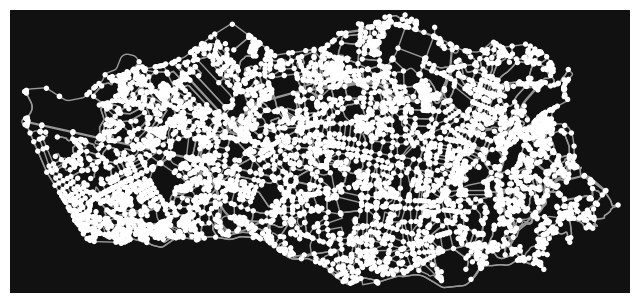

--- 14.776643991470337 seconds ---


In [14]:
#(download the entire porto network based on the polylines provided by OSM)
#Save graph to use as input for cyang's FMM (Extract Whole Porto)

#change the place as required. 
network_name = 'porto_whole1_new' #porto_whole1 / porto_big
place ="Porto, Portugal"

import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np
%matplotlib inline


start_time = time.time()
G = ox.graph_from_place(place, network_type='drive')
save_graph_shapefile_directional(G, filepath='./' + network_name)
fig, ax = ox.plot_graph(G)
ox.save_graphml(G, filepath = './' + network_name + '/saved_osmnx_graph')
print("--- %s seconds ---" % (time.time() - start_time))


### SHOW SOME EDGES DATA

In [15]:
import geopandas as gp
print("Show some sample edges from the graph")
edge_dataframe = gp.GeoDataFrame.from_file(network_name + "/edges.shp")

print("Total edges in the graph: ", len(edge_dataframe))
edge_dataframe[0:10]

Show some sample edges from the graph
Total edges in the graph:  11095


,u,v,key,osmid,oneway,highway,reversed,length,lanes,ref,maxspeed,bridge,name,width,access,junction,tunnel,area,fid,geometry
0,25503936,4722746638,0,479127843,1,motorway_link,False,32.388,None,None,None,None,None,None,None,None,None,None,0,"LINESTRING (-8.64064 41.16607, -8.64091 41.16628)"
1,25503936,281726624,0,4256507,1,motorway_link,False,224.655,None,None,None,None,None,None,None,None,None,None,1,"LINESTRING (-8.64064 41.16607, -8.64072 41.166..."
2,25503951,1243857957,0,4256513,1,motorway_link,False,115.105,1,IC 1,60,None,None,None,None,None,None,None,2,"LINESTRING (-8.64204 41.16835, -8.64234 41.168..."
3,25503951,4507024043,0,158906049,1,motorway_link,False,191.892,1,None,None,None,None,None,None,None,None,None,3,"LINESTRING (-8.64204 41.16835, -8.64222 41.168..."
4,25504027,1243857999,0,"[4256491, 108390772, 479127839]",1,motorway_link,False,118.915,"['2', '1']",None,40,yes,None,None,None,None,None,None,4,"LINESTRING (-8.64159 41.16689, -8.64173 41.167..."
5,25504163,25504183,0,"[479198379, 479198374]",1,trunk,False,77.190,3,"['EN 14', 'EN 14;EN 13']",90,None,Via Norte,None,None,None,None,None,5,"LINESTRING (-8.62241 41.17423, -8.62243 41.174..."
6,25504183,2486710630,0,"[479198378, 427967026]",1,trunk,False,272.900,4,"['EN 14', 'EN 14;EN 13']",90,None,Via Norte,None,None,None,None,None,6,"LINESTRING (-8.62244 41.17493, -8.62243 41.175..."
7,25507552,413275483,0,"[35006698, 34711004]",1,motorway,False,560.140,3,"['IC 23;A 20', 'IP1']",80,yes,Via de Cintura Interna,None,None,None,None,None,7,"LINESTRING (-8.58357 41.16624, -8.58334 41.166..."
8,25507552,409114759,0,"[34884993, 480148036, 497147261]",1,motorway_link,False,283.215,2,None,"['40', '50']",yes,None,None,None,None,None,None,8,"LINESTRING (-8.58357 41.16624, -8.58332 41.165..."
9,25507559,1731168926,0,480148045,1,motorway,False,321.704,3,IC 23;A 20,80,yes,Via de Cintura Interna,None,None,None,None,None,9,"LINESTRING (-8.58106 41.16261, -8.58110 41.162..."


### SHOW SOME NODES DATA

In [16]:
import geopandas as gp
print("Show some sample nodes from the graph")
nodes_dataframe = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")

print("Total nodes in the graph: ", len(nodes_dataframe))
nodes_dataframe.head()

Show some sample nodes from the graph
Total nodes in the graph:  5210


,osmid,y,x,street_cou,highway,ref,geometry
0,25503936,41.166071,-8.640636,3,None,None,POINT (-8.64064 41.16607)
1,25503951,41.168347,-8.642045,3,None,None,POINT (-8.64204 41.16835)
2,25504027,41.166885,-8.641587,3,None,None,POINT (-8.64159 41.16689)
3,25504163,41.174232,-8.622406,3,None,None,POINT (-8.62241 41.17423)
4,25504183,41.174925,-8.622444,3,None,None,POINT (-8.62244 41.17493)
